# Previsão de Preço de Ações com LSTM
Este notebook utiliza uma rede neural LSTM para prever o preço de fechamento de uma ação com base em dados históricos.

## 1. Importação de bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
import os
import joblib

## 2. Carregamento e preparação dos dados

In [2]:
df = pd.read_csv('../data/dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]
df.head()

,Close
Date,
2018-01-02,23.603912
2018-01-03,23.462471
2018-01-04,23.558649
2018-01-05,23.926401
2018-01-08,24.458227


In [3]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [4]:
# Divisão entre treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

## 3. Função para criação dos datasets com janela deslizante

In [5]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [6]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Ajuste do shape para LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 4. Criação e treino do modelo LSTM

In [7]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='nadam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5)
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0740
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0042
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0035
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033
Epoch 13/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031
Epoch 14/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034
Epoch 15/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

## 5. Avaliação do modelo

In [8]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inversão da normalização
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [9]:
train_rmse = np.sqrt(np.mean((train_predict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))
mae = mean_absolute_error(y_test, test_predict)
mape = mean_absolute_percentage_error(y_test, test_predict)

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test MAPE: {mape:.4%}')

Train RMSE: 2.0588
Test RMSE: 1.6038
Test MAE: 1.2297
Test MAPE: 2.1013%


## 6. Visualização das previsões

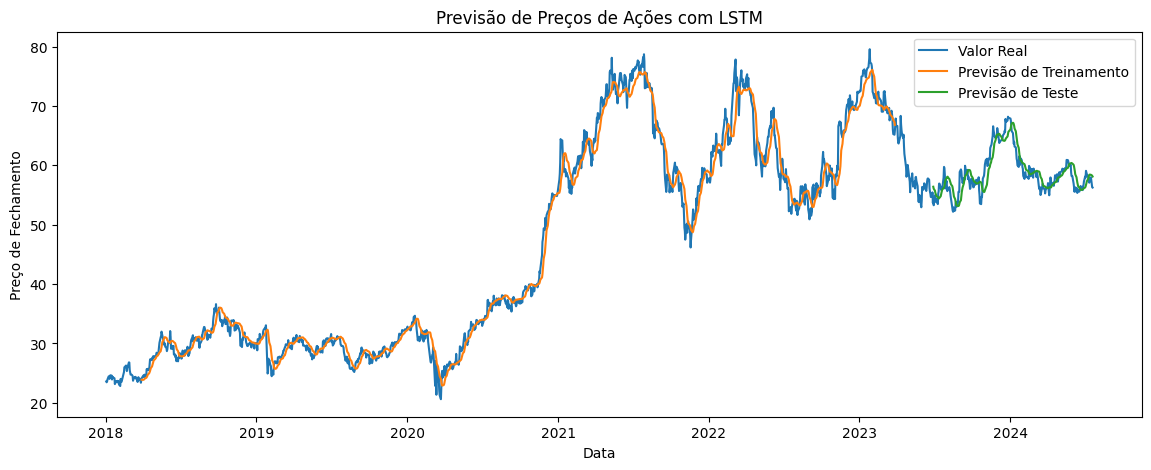

In [10]:
# Alinhar previsões com o índice de datas
train_plot = np.full_like(df['Close'].values, np.nan)
test_plot = np.full_like(df['Close'].values, np.nan)
train_plot[time_step:len(train_predict) + time_step] = train_predict.flatten()
test_plot[len(df) - len(test_predict):] = test_predict.flatten()

plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Close'], label='Valor Real')
plt.plot(df.index, train_plot, label='Previsão de Treinamento')
plt.plot(df.index, test_plot, label='Previsão de Teste')
plt.title('Previsão de Preços de Ações com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [11]:
# Salvando o modelo no formato novo do keras
model.save('../models/lstm_model.keras')
joblib.dump(scaler, '../models/scaler.save')

['../models/scaler.save']